In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

## Configuration

In [137]:
# Paths
# DATASET_NAME = "E2H-GSM8K"
# DATASET_NAME = "AIME_1983_2024"
DATASET_NAME = "GSM_HARD"
# DATASET_NAME = "AIME_2025"
MODEL_ALIAS = "Qwen2.5-Math-1.5B-Instruct"
GEN_STR = "max_3000_k_1_temp_0.0"
RESULTS_DIR = Path(f"../predicting_learnability/SELF_CONCISTENCY_EXPERIMENTS/{DATASET_NAME}/predicting_MATH_learnability_{MODEL_ALIAS}_{GEN_STR}_probe")

# Token pricing (USD per 1M tokens)
INPUT_TOKEN_PRICE = 0.25  # $0.25 per 1M input tokens
OUTPUT_TOKEN_PRICE = 1.00  # $1.00 per 1M output tokens

# Average prompt length (we'll estimate this)
AVG_PROMPT_TOKENS = 100  # typical math problem prompt

print(f"Loading results from: {RESULTS_DIR}")
print(f"\nPricing:")
print(f"  Input:  ${INPUT_TOKEN_PRICE:.2f} / 1M tokens")
print(f"  Output: ${OUTPUT_TOKEN_PRICE:.2f} / 1M tokens")

Loading results from: ../predicting_learnability/SELF_CONCISTENCY_EXPERIMENTS/GSM_HARD/predicting_MATH_learnability_Qwen2.5-Math-1.5B-Instruct_max_3000_k_1_temp_0.0_probe

Pricing:
  Input:  $0.25 / 1M tokens
  Output: $1.00 / 1M tokens


## Load Results

In [138]:
# Load all strategy results
strategies = ['all_greedy', 'all_sc', 'random_30pct', 'probe_threshold_0.50', 'probe_quantile_bottom_10pct', 'probe_quantile_bottom_30pct']

results = {}
for strategy in strategies:
    file_path = RESULTS_DIR / f"{MODEL_ALIAS}_{strategy}_results.parquet"
    if file_path.exists():
        df = pd.read_parquet(file_path)
        # df["predicted_success_prob"] = 1 / (1 + np.exp(-df["predicted_score"]))
        df["predicted_success_prob"] = df["predicted_score"]
        results[strategy] = df
        print(f"✓ Loaded {strategy}: {len(df)} questions, {df['total_tokens'].sum():,} total tokens")
    else:
        print(f"✗ Missing {strategy}")

print(f"\nLoaded {len(results)} strategies")

✓ Loaded all_greedy: 1319 questions, 696,695 total tokens
✓ Loaded all_sc: 1319 questions, 3,672,108 total tokens
✓ Loaded random_30pct: 1319 questions, 1,665,604 total tokens
✓ Loaded probe_threshold_0.50: 1319 questions, 3,127,686 total tokens
✓ Loaded probe_quantile_bottom_10pct: 1319 questions, 1,009,229 total tokens
✓ Loaded probe_quantile_bottom_30pct: 1319 questions, 1,675,504 total tokens

Loaded 6 strategies


## Compute Token Costs

In [26]:
def calculate_cost(df, avg_prompt_tokens=AVG_PROMPT_TOKENS):
    """
    Calculate total cost for a strategy.
    
    Cost = (input_tokens × input_price) + (output_tokens × output_price)
    
    For each question:
    - Input tokens = num_samples × avg_prompt_tokens
    - Output tokens = total_tokens (already stored)
    """
    # Input cost: each sample requires a full prompt
    total_input_tokens = (df['num_samples'] * avg_prompt_tokens).sum()
    input_cost = (total_input_tokens / 1_000_000) * INPUT_TOKEN_PRICE
    
    # Output cost: generated tokens
    total_output_tokens = df['total_tokens'].sum()
    output_cost = (total_output_tokens / 1_000_000) * OUTPUT_TOKEN_PRICE
    
    total_cost = input_cost + output_cost
    
    return {
        'total_input_tokens': total_input_tokens,
        'total_output_tokens': total_output_tokens,
        'input_cost': input_cost,
        'output_cost': output_cost,
        'total_cost': total_cost,
        'num_questions': len(df),
        'num_correct': df['is_correct'].sum(),
        'accuracy': df['is_correct'].mean(),
    }

# Calculate costs for all strategies
cost_data = {}
for strategy, df in results.items():
    cost_data[strategy] = calculate_cost(df)

# Create summary DataFrame
cost_df = pd.DataFrame(cost_data).T
cost_df['cost_per_question'] = cost_df['total_cost'] / cost_df['num_questions']
cost_df['cost_per_correct'] = cost_df['total_cost'] / cost_df['num_correct']
cost_df['cost_per_accuracy_point'] = cost_df['total_cost'] / (cost_df['accuracy'] * 100)

cost_df

,total_input_tokens,total_output_tokens,input_cost,output_cost,total_cost,num_questions,num_correct,accuracy,cost_per_question,cost_per_correct,cost_per_accuracy_point
all_greedy,1500.0,12272.0,0.000375,0.012272,0.012647,15.0,2.0,0.133333,0.000843,0.006324,0.000949
all_sc,7500.0,85810.0,0.001875,0.085810,0.087685,15.0,1.0,0.066667,0.005846,0.087685,0.013153
random,3900.0,44330.0,0.000975,0.044330,0.045305,15.0,2.0,0.133333,0.003020,0.022652,0.003398
probe_threshold,6300.0,66656.0,0.001575,0.066656,0.068231,15.0,2.0,0.133333,0.004549,0.034116,0.005117
probe_quantile,2300.0,20009.0,0.000575,0.020009,0.020584,15.0,2.0,0.133333,0.001372,0.010292,0.001544


## Load Comparison Data (for baseline)

In [16]:
# Load the routing comparison CSV for additional context
comparison_file = RESULTS_DIR / "routing_comparison.csv"
if comparison_file.exists():
    comparison_df = pd.read_csv(comparison_file)
    print("Routing Comparison Data:")
    print(comparison_df.to_string(index=False))
    
    # Merge with cost data
    comparison_df['strategy_key'] = comparison_df['Strategy'].str.replace('-', '_')
    cost_df['strategy_name'] = cost_df.index
    
    # Join on strategy names
    merged = comparison_df.merge(
        cost_df,
        left_on='strategy_key',
        right_on='strategy_name',
        how='left'
    )
else:
    print("No comparison data found")
    merged = cost_df

Routing Comparison Data:
       Strategy  Accuracy  Accuracy Gain  Fraction SC  Avg Samples  Efficiency  Router Acc  Router Prec  Router Recall
 probe_quantile  0.200000       0.066667     0.333333     2.333333    0.028571    0.333333     0.800000       0.307692
     all_greedy  0.133333       0.000000     0.000000     1.000000    0.000000    0.133333     0.000000       0.000000
probe_threshold  0.133333       0.000000     0.800000     4.200000    0.000000    0.666667     0.833333       0.769231
         random  0.133333       0.000000     0.400000     2.600000    0.000000    0.400000     0.833333       0.384615
 probe_quantile  0.133333       0.000000     0.133333     1.533333    0.000000    0.266667     1.000000       0.153846
         all_sc  0.066667      -0.066667     1.000000     5.000000   -0.013333    0.866667     0.866667       1.000000


## Cost Analysis Summary

In [17]:
print("="*80)
print("💰 COST ANALYSIS SUMMARY")
print("="*80)
print()

# Find baseline (all_greedy)
baseline_cost = cost_df.loc['all_greedy', 'total_cost']
baseline_accuracy = cost_df.loc['all_greedy', 'accuracy']

print(f"Baseline (all_greedy):")
print(f"  Cost: ${baseline_cost:.4f}")
print(f"  Accuracy: {baseline_accuracy:.2%}")
print()

# Calculate ROI for each strategy
cost_df['cost_increase'] = cost_df['total_cost'] - baseline_cost
cost_df['accuracy_increase'] = cost_df['accuracy'] - baseline_accuracy
cost_df['roi'] = cost_df['accuracy_increase'] / (cost_df['cost_increase'] + 1e-10)  # avoid div by zero
cost_df['roi_pct'] = cost_df['roi'] * 100  # accuracy points per dollar

# Sort by ROI
roi_sorted = cost_df.sort_values('roi', ascending=False)

print("Strategy Rankings by ROI (Accuracy Gain per $ Spent):")
print("─" * 80)
for idx, (strategy, row) in enumerate(roi_sorted.iterrows(), 1):
    if strategy == 'all_greedy':
        print(f"{idx}. {strategy:<20} [BASELINE]")
    else:
        print(f"{idx}. {strategy:<20} "
              f"ROI: {row['roi_pct']:>8.2f} acc pts/$  "
              f"| Cost: ${row['total_cost']:>7.4f} ({row['cost_increase']/baseline_cost*100:>+6.1f}%)  "
              f"| Acc: {row['accuracy']:>6.2%} ({row['accuracy_increase']:>+6.2%})")

print("\n" + "="*80)

💰 COST ANALYSIS SUMMARY

Baseline (all_greedy):
  Cost: $0.0126
  Accuracy: 13.33%

Strategy Rankings by ROI (Accuracy Gain per $ Spent):
────────────────────────────────────────────────────────────────────────────────
1. all_greedy           [BASELINE]
2. random               ROI:     0.00 acc pts/$  | Cost: $ 0.0453 (+258.2%)  | Acc: 13.33% (+0.00%)
3. probe_threshold      ROI:     0.00 acc pts/$  | Cost: $ 0.0682 (+439.5%)  | Acc: 13.33% (+0.00%)
4. probe_quantile       ROI:     0.00 acc pts/$  | Cost: $ 0.0206 ( +62.8%)  | Acc: 13.33% (+0.00%)
5. all_sc               ROI:   -88.84 acc pts/$  | Cost: $ 0.0877 (+593.3%)  | Acc:  6.67% (-6.67%)



## Visualization: Cost vs Accuracy

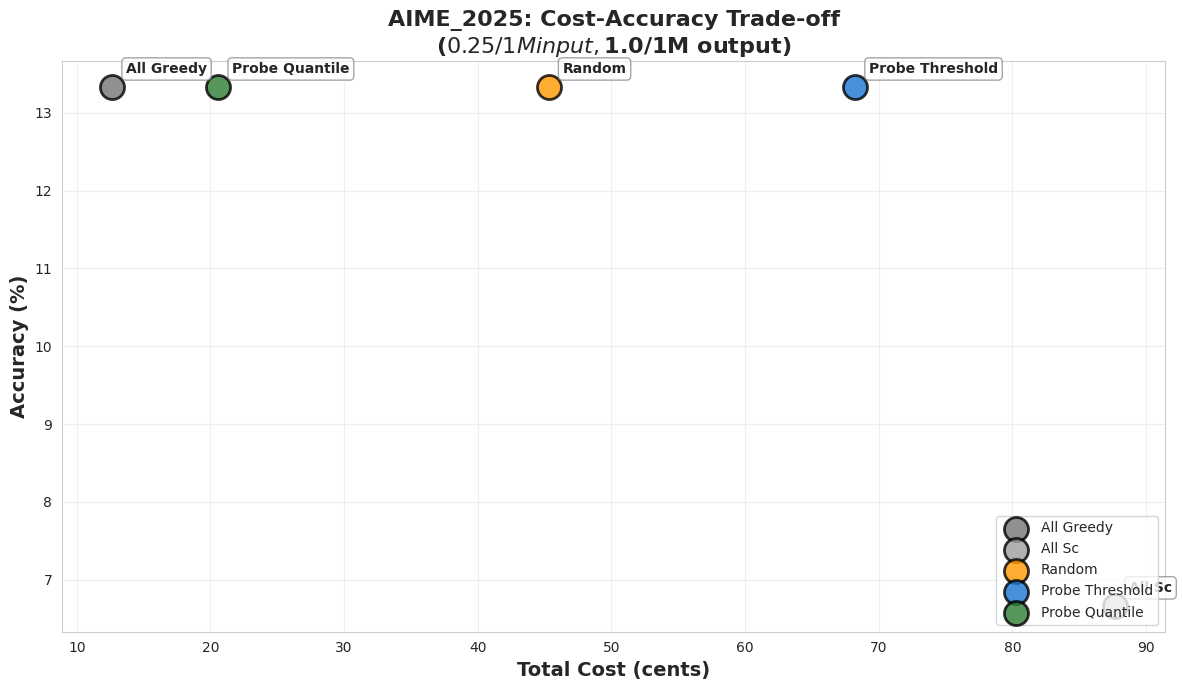


🎯 Pareto-optimal strategies (best cost-accuracy frontier): all_greedy


In [18]:
fig, ax = plt.subplots(figsize=(12, 7))

# Color mapping
color_map = {
    'all_greedy': '#757575',
    'all_sc': '#9E9E9E',
    'random': '#FF9800',
    'probe_threshold': '#1976D2',
    'probe_quantile': '#2E7D32',
}

for strategy in cost_df.index:
    ax.scatter(
        cost_df.loc[strategy, 'total_cost'] * 1000,  # convert to cents for readability
        cost_df.loc[strategy, 'accuracy'] * 100,  # percentage
        s=300,
        alpha=0.8,
        color=color_map.get(strategy, '#BDBDBD'),
        edgecolor='black',
        linewidth=2,
        label=strategy.replace('_', ' ').title()
    )
    
    # Annotate
    ax.annotate(
        strategy.replace('_', ' ').title(),
        (cost_df.loc[strategy, 'total_cost'] * 1000, cost_df.loc[strategy, 'accuracy'] * 100),
        xytext=(10, 10),
        textcoords='offset points',
        fontsize=10,
        fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.7)
    )

# Draw Pareto frontier (cost-efficiency frontier)
sorted_by_cost = cost_df.sort_values('total_cost')
pareto_points = []
max_acc = 0
for strategy in sorted_by_cost.index:
    acc = cost_df.loc[strategy, 'accuracy']
    if acc > max_acc:
        pareto_points.append(strategy)
        max_acc = acc

if len(pareto_points) > 1:
    pareto_costs = [cost_df.loc[s, 'total_cost'] * 1000 for s in pareto_points]
    pareto_accs = [cost_df.loc[s, 'accuracy'] * 100 for s in pareto_points]
    ax.plot(pareto_costs, pareto_accs, 'r--', linewidth=2, alpha=0.5, label='Pareto Frontier')

ax.set_xlabel('Total Cost (cents)', fontsize=14, fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
ax.set_title(f'{DATASET_NAME}: Cost-Accuracy Trade-off\n(${INPUT_TOKEN_PRICE}/1M input, ${OUTPUT_TOKEN_PRICE}/1M output)', 
             fontsize=16, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'cost_vs_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n🎯 Pareto-optimal strategies (best cost-accuracy frontier): {', '.join(pareto_points)}")

## Cost per Correct Answer

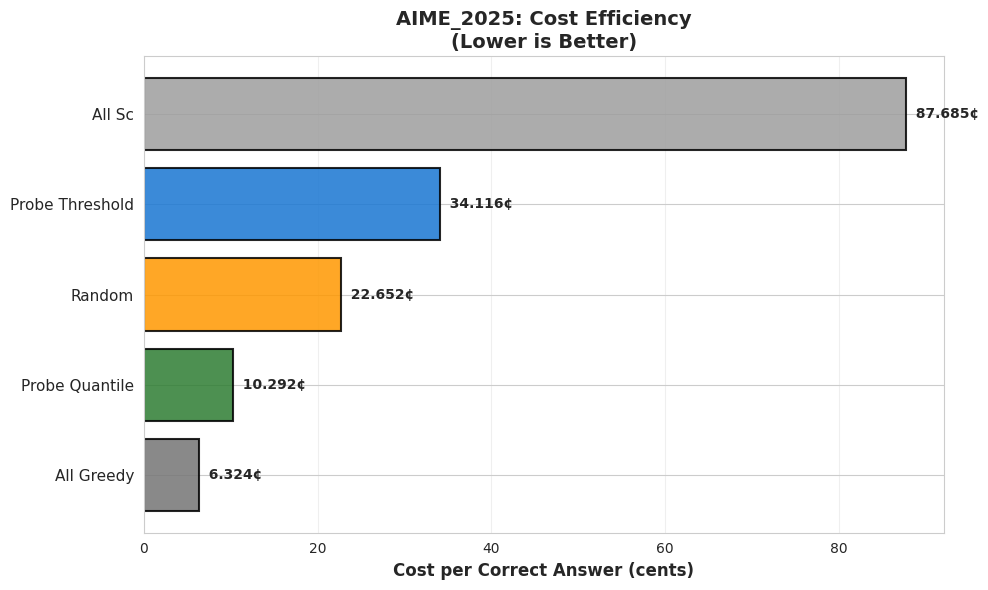


💡 Key Insight:
   All Greedy is 13.9x more cost-efficient than All Sc


In [19]:
fig, ax = plt.subplots(figsize=(10, 6))

strategies_sorted = cost_df.sort_values('cost_per_correct')['cost_per_correct']
colors = [color_map.get(s, '#BDBDBD') for s in strategies_sorted.index]

bars = ax.barh(range(len(strategies_sorted)), strategies_sorted * 1000, color=colors, alpha=0.85, edgecolor='black', linewidth=1.5)
ax.set_yticks(range(len(strategies_sorted)))
ax.set_yticklabels([s.replace('_', ' ').title() for s in strategies_sorted.index], fontsize=11)
ax.set_xlabel('Cost per Correct Answer (cents)', fontsize=12, fontweight='bold')
ax.set_title(f'{DATASET_NAME}: Cost Efficiency\n(Lower is Better)', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, (strategy, cost) in enumerate(strategies_sorted.items()):
    ax.text(cost * 1000, i, f'  {cost*1000:.3f}¢', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'cost_per_correct.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💡 Key Insight:")
best = strategies_sorted.index[0]
worst = strategies_sorted.index[-1]
print(f"   {best.replace('_', ' ').title()} is {strategies_sorted[worst]/strategies_sorted[best]:.1f}x more cost-efficient than {worst.replace('_', ' ').title()}")

## ROI Analysis: Accuracy Gain per Dollar

No strategies improve over baseline


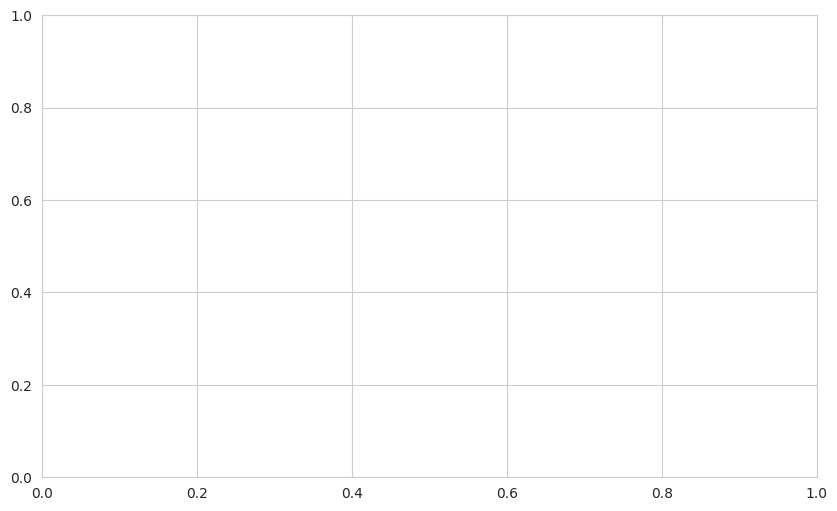

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))

# Only show strategies that improve over baseline
roi_positive = cost_df[cost_df['accuracy_increase'] > 0].sort_values('roi', ascending=True)

if len(roi_positive) > 0:
    colors = [color_map.get(s, '#BDBDBD') for s in roi_positive.index]
    
    bars = ax.barh(range(len(roi_positive)), roi_positive['roi_pct'], color=colors, alpha=0.85, edgecolor='black', linewidth=1.5)
    ax.set_yticks(range(len(roi_positive)))
    ax.set_yticklabels([s.replace('_', ' ').title() for s in roi_positive.index], fontsize=11)
    ax.set_xlabel('Accuracy Points Gained per Dollar Spent', fontsize=12, fontweight='bold')
    ax.set_title(f'{DATASET_NAME}: Return on Investment (ROI)\n(Higher is Better)', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (strategy, row) in enumerate(roi_positive.iterrows()):
        ax.text(row['roi_pct'], i, f'  {row["roi_pct"]:.1f}', va='center', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'roi_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n🚀 Winner:")
    best_roi = roi_positive.iloc[-1]
    print(f"   {best_roi.name.replace('_', ' ').title()} delivers {best_roi['roi_pct']:.1f} accuracy points per dollar spent")
    print(f"   That's a {best_roi['accuracy_increase']:.2%} improvement for just ${best_roi['cost_increase']:.4f} extra")
else:
    print("No strategies improve over baseline")

## Token Breakdown Analysis

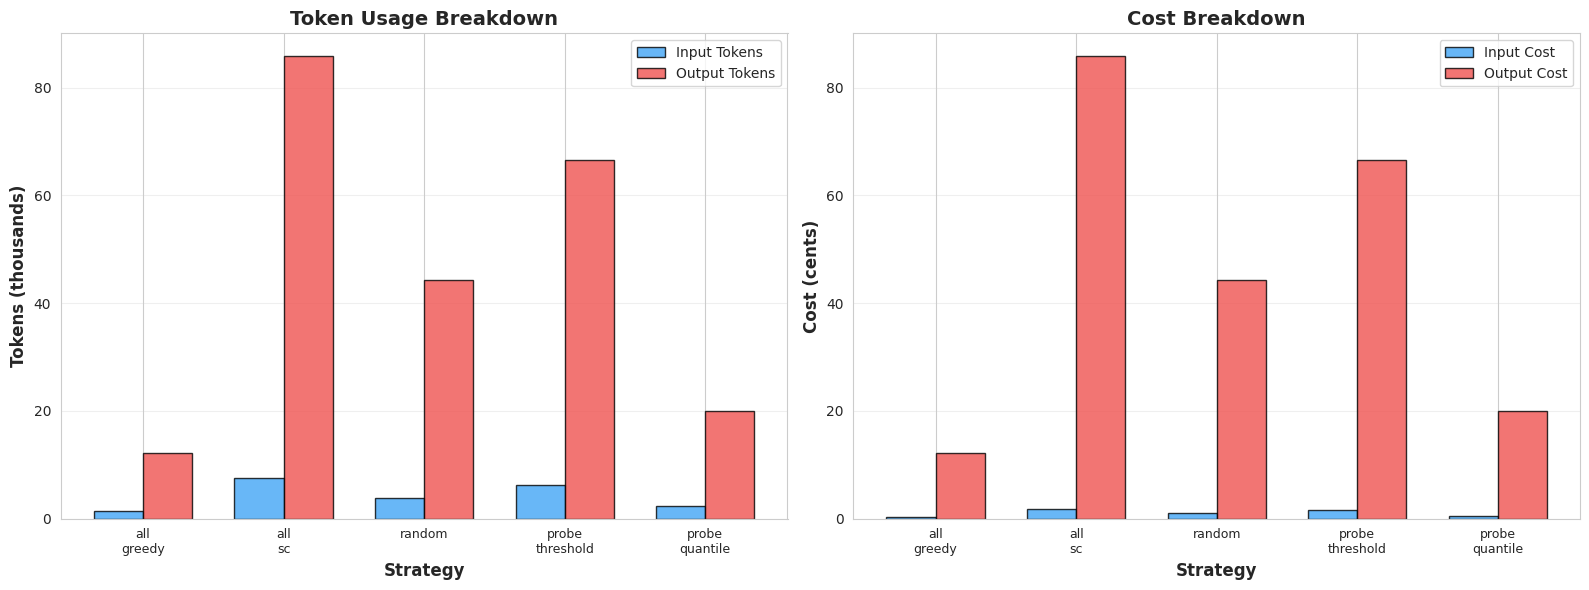


📊 Token Economics:
   all_greedy           Input:   3.0% | Output:  97.0%
   all_sc               Input:   2.1% | Output:  97.9%
   random               Input:   2.2% | Output:  97.8%
   probe_threshold      Input:   2.3% | Output:  97.7%
   probe_quantile       Input:   2.8% | Output:  97.2%


In [21]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Input vs Output tokens
ax1 = axes[0]
strategies_list = list(cost_df.index)
input_tokens = [cost_df.loc[s, 'total_input_tokens'] / 1000 for s in strategies_list]  # in thousands
output_tokens = [cost_df.loc[s, 'total_output_tokens'] / 1000 for s in strategies_list]

x = np.arange(len(strategies_list))
width = 0.35

bars1 = ax1.bar(x - width/2, input_tokens, width, label='Input Tokens', color='#42A5F5', alpha=0.8, edgecolor='black')
bars2 = ax1.bar(x + width/2, output_tokens, width, label='Output Tokens', color='#EF5350', alpha=0.8, edgecolor='black')

ax1.set_xlabel('Strategy', fontsize=12, fontweight='bold')
ax1.set_ylabel('Tokens (thousands)', fontsize=12, fontweight='bold')
ax1.set_title('Token Usage Breakdown', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels([s.replace('_', '\n') for s in strategies_list], fontsize=9)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Right plot: Cost breakdown
ax2 = axes[1]
input_costs = [cost_df.loc[s, 'input_cost'] * 1000 for s in strategies_list]  # in cents
output_costs = [cost_df.loc[s, 'output_cost'] * 1000 for s in strategies_list]

bars3 = ax2.bar(x - width/2, input_costs, width, label='Input Cost', color='#42A5F5', alpha=0.8, edgecolor='black')
bars4 = ax2.bar(x + width/2, output_costs, width, label='Output Cost', color='#EF5350', alpha=0.8, edgecolor='black')

ax2.set_xlabel('Strategy', fontsize=12, fontweight='bold')
ax2.set_ylabel('Cost (cents)', fontsize=12, fontweight='bold')
ax2.set_title('Cost Breakdown', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([s.replace('_', '\n') for s in strategies_list], fontsize=9)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'token_cost_breakdown.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Token Economics:")
for strategy in strategies_list:
    input_pct = cost_df.loc[strategy, 'input_cost'] / cost_df.loc[strategy, 'total_cost'] * 100
    output_pct = cost_df.loc[strategy, 'output_cost'] / cost_df.loc[strategy, 'total_cost'] * 100
    print(f"   {strategy:<20} Input: {input_pct:>5.1f}% | Output: {output_pct:>5.1f}%")

## Final Summary Table

In [22]:
print("\n" + "="*100)
print("📋 COMPLETE COST-EFFICIENCY SUMMARY")
print("="*100)
print()

summary = cost_df[[
    'accuracy', 
    'total_cost', 
    'cost_per_question',
    'cost_per_correct',
    'accuracy_increase',
    'cost_increase',
    'roi_pct'
]].copy()

summary.columns = ['Accuracy', 'Total Cost ($)', 'Cost/Q ($)', 'Cost/Correct ($)', 'Acc Δ', 'Cost Δ ($)', 'ROI (pts/$)']
summary = summary.sort_values('ROI (pts/$)', ascending=False)

# Format for display
summary['Accuracy'] = summary['Accuracy'].apply(lambda x: f"{x:.2%}")
summary['Total Cost ($)'] = summary['Total Cost ($)'].apply(lambda x: f"${x:.4f}")
summary['Cost/Q ($)'] = summary['Cost/Q ($)'].apply(lambda x: f"${x:.6f}")
summary['Cost/Correct ($)'] = summary['Cost/Correct ($)'].apply(lambda x: f"${x:.6f}")
summary['Acc Δ'] = summary['Acc Δ'].apply(lambda x: f"{x:+.2%}")
summary['Cost Δ ($)'] = summary['Cost Δ ($)'].apply(lambda x: f"${x:+.4f}")
summary['ROI (pts/$)'] = summary['ROI (pts/$)'].apply(lambda x: f"{x:.1f}" if not np.isinf(x) else "∞")

print(summary.to_string())
print("\n" + "="*100)

# Export to CSV
cost_df.to_csv(RESULTS_DIR / 'token_cost_analysis.csv')
print(f"\n✅ Saved detailed results to: {RESULTS_DIR / 'token_cost_analysis.csv'}")


📋 COMPLETE COST-EFFICIENCY SUMMARY

                Accuracy Total Cost ($) Cost/Q ($) Cost/Correct ($)   Acc Δ Cost Δ ($) ROI (pts/$)
all_greedy        13.33%        $0.0126  $0.000843        $0.006324  +0.00%   $+0.0000         0.0
random            13.33%        $0.0453  $0.003020        $0.022652  +0.00%   $+0.0327         0.0
probe_threshold   13.33%        $0.0682  $0.004549        $0.034116  +0.00%   $+0.0556         0.0
probe_quantile    13.33%        $0.0206  $0.001372        $0.010292  +0.00%   $+0.0079         0.0
all_sc             6.67%        $0.0877  $0.005846        $0.087685  -6.67%   $+0.0750       -88.8


✅ Saved detailed results to: ../predicting_learnability/MAJORITY_VOTE_DATA/AIME_2025/predicting_MATH_learnability_Qwen2.5-Math-1.5B-Instruct_max_3000_k_1_temp_0.0_probe/token_cost_analysis.csv


## Key Takeaways

### Questions to Answer:
1. **Which strategy gives the best bang for your buck?**
   - Look at the ROI metric (accuracy points per dollar)
   
2. **Is SC-on-everything worth the 5x token cost?**
   - Compare `all_sc` vs `all_greedy` cost increase vs accuracy gain
   
3. **Does probe-based routing save money while maintaining accuracy?**
   - Check if probe strategies are on the Pareto frontier
   
4. **What's the marginal cost of each accuracy point?**
   - `cost_per_accuracy_point` shows $/1% accuracy gain

### Next Steps:
- Try different token pricing models (e.g., local inference vs API)
- Analyze cost-latency trade-offs (SC is slower)
- Compute amortized costs over large datasets
- Factor in training costs for the probe model